Step -1 : Load and Inspect the Dataset

In [1]:
import pandas as pd
import numpy as np 

# Load the dataset
df = pd.read_csv('student_data.csv')

# Inspect the dataset
print(df.head())        # View the first 5 rows
print(df.info())        # Summary of columns and data types
print(df.describe())    # Statistics for numerical columns

# Check for missing values
print(df.isnull().sum())

   Student ID  Operating System  DSA  Frontend  Backend  Machine Learning  \
0           1                61   89        40       77                41   
1           2                43   32        75       66                46   
2           3                87   25        65       32                98   
3           4                87   46        66       51                89   
4           5                40   80        62       26                89   

   Data Analytics  Attendance (Operating System)  Attendance (DSA)  \
0              90                             94                98   
1              29                             61                68   
2              87                             77                56   
3              55                             61                58   
4              71                             91                96   

   Attendance (Frontend)  Attendance (Backend)  Attendance (Machine Learning)  \
0                     72           

Step 2 : Preprocess the Data

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Select numerical features
numerical_features = df[['Operating System', 'DSA', 'Frontend', 'Backend', 
                         'Machine Learning', 'Data Analytics',
                         'Attendance (Operating System)', 'Attendance (DSA)', 
                         'Attendance (Frontend)', 'Attendance (Backend)', 
                         'Attendance (Machine Learning)', 'Attendance (Data Analytics)']]

# Scale numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_features)

# Encode project domains
project_columns = ['Project 1', 'Project 2', 'Project 3', 'Project 4']
projects_encoded = pd.get_dummies(df[project_columns].stack()).groupby(level=0).sum()

# Combine scaled numerical features and encoded project data
final_data = pd.concat([pd.DataFrame(scaled_features, columns=numerical_features.columns), projects_encoded], axis=1)

Step 3 : Apply K-Means Clustering

In [3]:
from sklearn.cluster import KMeans

# Apply K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(final_data)

# Inspect cluster assignments
print(df[['Cluster']].value_counts())


Cluster
1          356
0          337
2          307
Name: count, dtype: int64


Step 4 : Visualizing the Clusters

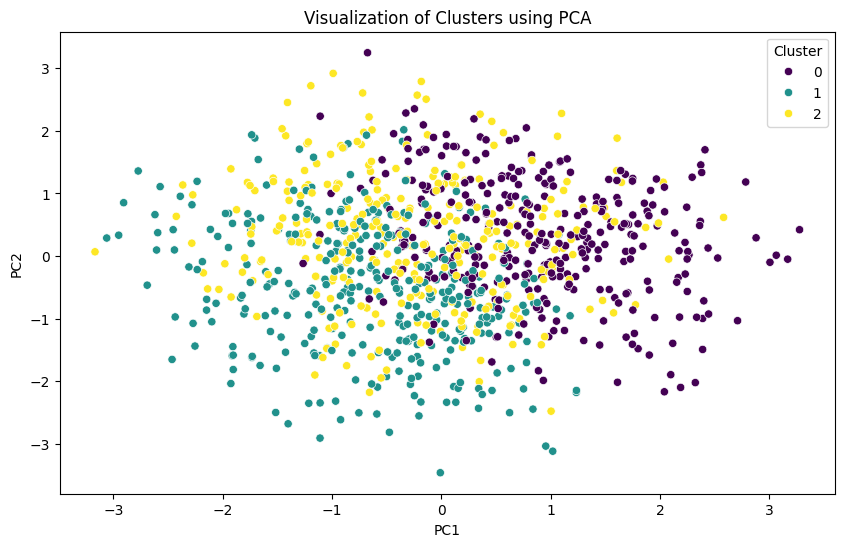

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Reduce to 2 dimensions using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(final_data)

# Create a DataFrame for visualization
df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
df_pca['Cluster'] = df['Cluster']

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette='viridis', data=df_pca)
plt.title('Visualization of Clusters using PCA')
plt.show()

Step 5 : Analyze Each Cluster

In [5]:
# Select only numeric columns for mean calculation
numeric_cols = df.select_dtypes(include=[np.number]).columns  # Only numeric data
cluster_analysis = df.groupby('Cluster')[numeric_cols].mean()

print(cluster_analysis)  # This will now work correctly!

         Student ID  Operating System        DSA   Frontend    Backend  \
Cluster                                                                  
0        495.863501         68.308605  58.839763  50.798220  54.715134   
1        499.014045         56.780899  59.660112  78.075843  59.199438   
2        507.312704         66.332248  69.671010  59.166124  72.811075   

         Machine Learning  Data Analytics  Attendance (Operating System)  \
Cluster                                                                    
0               68.035608       57.442136                      81.519288   
1               66.196629       65.174157                      75.255618   
2               53.996743       62.599349                      66.758958   

         Attendance (DSA)  Attendance (Frontend)  Attendance (Backend)  \
Cluster                                                                  
0               81.026706              76.934718             78.489614   
1               66.058989 

In [6]:
# Find the most common projects in each cluster
for cluster in df['Cluster'].unique():
    print(f"\nCluster {cluster} - Most Common Projects:")
    print(df[df['Cluster'] == cluster][['Project 1', 'Project 2', 'Project 3', 'Project 4']].mode())



Cluster 2 - Most Common Projects:
      Project 1     Project 2        Project 3         Project 4
0  Data Science  Data Science  Web Development  Machine Learning

Cluster 0 - Most Common Projects:
          Project 1     Project 2         Project 3         Project 4
0  Game Development  Data Science  Game Development  Game Development

Cluster 1 - Most Common Projects:
       Project 1      Project 2 Project 3      Project 4
0  Cybersecurity  Cybersecurity  Robotics  Cybersecurity


Step 6 :  Interpret and Label Clusters

In [7]:
# Define cluster labels
cluster_labels = {
    0: "High Performers",
    1: "Moderate Performers",
    2: "Project Enthusiasts"
}

# Map cluster labels to DataFrame
df['Cluster Label'] = df['Cluster'].map(cluster_labels)

# Display the first few rows
print(df[['Student ID', 'Cluster', 'Cluster Label']].head())

   Student ID  Cluster        Cluster Label
0           1        2  Project Enthusiasts
1           2        2  Project Enthusiasts
2           3        0      High Performers
3           4        1  Moderate Performers
4           5        0      High Performers


Step 7 : Identify Strong & Weak Subjects for Each Student

In [8]:
# Define thresholds

strong_threshold = 85
weak_threshold = 65

subjects = ['Operating System', 'DSA', 'Frontend', 'Backend', 'Machine Learning', 'Data Analytics']

# Function to determine strong and weak subjects for a student
def categorize_subjects(row):
    strong = [subject for subject in subjects if row[subject] >= strong_threshold]
    weak = [subject for subject in subjects if row[subject] <= weak_threshold]
    return pd.Series([', '.join(strong), ', '.join(weak)])

# Apply function to dataset
df[['Strong Subjects', 'Weak Subjects']] = df.apply(categorize_subjects, axis=1)

# Display results
print(df[['Student ID', 'Strong Subjects', 'Weak Subjects']].head())

   Student ID                                    Strong Subjects  \
0           1                                DSA, Data Analytics   
1           2                                                      
2           3  Operating System, Machine Learning, Data Analy...   
3           4                 Operating System, Machine Learning   
4           5                                   Machine Learning   

                                       Weak Subjects  
0       Operating System, Frontend, Machine Learning  
1  Operating System, DSA, Machine Learning, Data ...  
2                             DSA, Frontend, Backend  
3                       DSA, Backend, Data Analytics  
4                Operating System, Frontend, Backend  


Step 8 :  Generate Summary Statistics for Each Cluster

In [9]:
from collections import Counter

def count_subjects(series):
    all_subjects = []
    for subjects in series:
        all_subjects.extend(subjects.split(', '))  # Splitting subject lists
    return pd.Series(Counter(all_subjects))  # Convert counts to Series

# Apply function to get counts
strong_subjects_cluster = df.groupby('Cluster')['Strong Subjects'].apply(count_subjects).unstack().fillna(0)
weak_subjects_cluster = df.groupby('Cluster')['Weak Subjects'].apply(count_subjects).unstack().fillna(0)

# Normalize to percentages (optional)
strong_subjects_cluster = strong_subjects_cluster.div(strong_subjects_cluster.sum(axis=1), axis=0)
weak_subjects_cluster = weak_subjects_cluster.div(weak_subjects_cluster.sum(axis=1), axis=0)

# Display summary
print("Strong subjects per cluster:\n", strong_subjects_cluster)
print("\nWeak subjects per cluster:\n", weak_subjects_cluster)


Strong subjects per cluster:
                     Backend       DSA  Data Analytics  Frontend  \
Cluster                                                           
0        0.216704  0.097065  0.112867        0.117381  0.047404   
1        0.096386  0.103270  0.122203        0.158348  0.268503   
2        0.153689  0.217213  0.202869        0.129098  0.081967   

         Machine Learning  Operating System  
Cluster                                      
0                0.187359          0.221219  
1                0.170396          0.080895  
2                0.063525          0.151639  

Weak subjects per cluster:
                     Backend       DSA  Data Analytics  Frontend  \
Cluster                                                           
0        0.000821  0.202791  0.168309        0.178161  0.214286   
1        0.004541  0.205268  0.196185        0.156222  0.077203   
2        0.004215  0.101159  0.135933        0.170706  0.198103   

         Machine Learning  Operating Sy

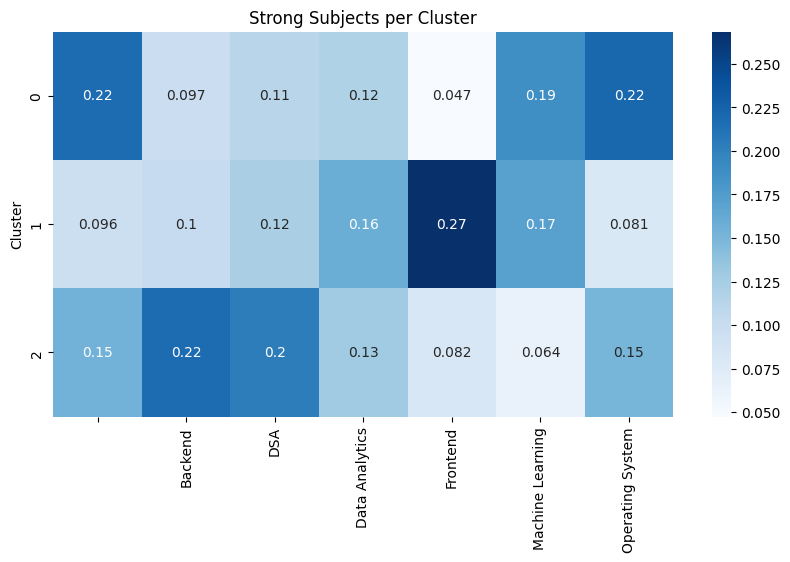

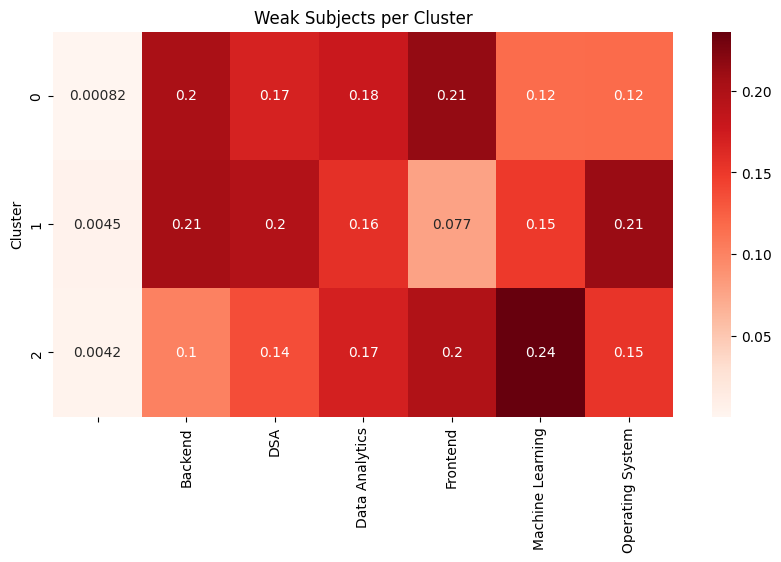

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.heatmap(strong_subjects_cluster, annot=True, cmap='Blues')
plt.title("Strong Subjects per Cluster")
plt.show()

plt.figure(figsize=(10,5))
sns.heatmap(weak_subjects_cluster, annot=True, cmap='Reds')
plt.title("Weak Subjects per Cluster")
plt.show()
